In [ ]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# 1. Load Data and Understanding Dataset

## 1. Data Upload

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler

In [ ]:
# Mount to gDrive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
# Use your own path
path = '/content/drive/My Drive/BADM 358/final project/' 

In [ ]:
# Create a SparkSession
spark = SparkSession.builder.appName('Twitter').getOrCreate()

In [ ]:
import pandas as pd
tweet_df = pd.read_csv(path+"Twitter_Jan_Mar.csv")

In [ ]:
tweet_df.head(10)

,date,id,content,username,like_count,retweet_count
0,2023-03-29 22:58:21+00:00,1641213230730051584,"Free AI marketing and automation tools, strate...",RealProfitPros,0.0,0.0
1,2023-03-29 22:58:18+00:00,1641213218520481805,@MecoleHardman4 Chat GPT says it’s 15. 😂,AmyLouWho321,0.0,0.0
2,2023-03-29 22:57:53+00:00,1641213115684536323,https://t.co/FjJSprt0te - Chat with any PDF!\n...,yjleon1976,0.0,0.0
3,2023-03-29 22:57:52+00:00,1641213110915571715,"AI muses: ""In the court of life, we must all f...",ChatGPT_Thinks,0.0,0.0
4,2023-03-29 22:57:26+00:00,1641213003260633088,Most people haven't heard of Chat GPT yet.\nFi...,nikocosmonaut,0.0,0.0
5,2023-03-29 22:57:20+00:00,1641212975012016128,@nytimes No! Chat Gpt has been putting togethe...,cordydbarb,0.0,0.0
6,2023-03-29 22:57:06+00:00,1641212917868646400,@ylzkrtt Yes also by chat gpt you can make gen...,gomezfidelphani,1.0,0.0
7,2023-03-29 22:57:02+00:00,1641212902375063552,@robinhanson @razibkhan Most people haven't he...,nikocosmonaut,0.0,0.0
8,2023-03-29 22:56:52+00:00,1641212856984109072,Yours Robotically - by Shaun Usher - Letters o...,lawyermarketer,0.0,0.0
9,2023-03-29 22:56:49+00:00,1641212845441585152,This is a metaphor for the limited perception ...,ashleighgrente2,2.0,0.0


In [ ]:
# check for missing values
print(tweet_df.isnull().sum())

date              0
id                6
content           6
username         34
like_count       62
retweet_count    62
dtype: int64


In [ ]:
# Remove missing values
tweet_df = tweet_df.dropna()
print("Length: ",len(tweet_df))

Length:  499974


In [ ]:
df = spark.createDataFrame(tweet_df)

## 2. Data Inspection

In [ ]:
# Show the first 10 rows of data
df.show(10)

+--------------------+-------------------+--------------------+---------------+----------+-------------+
|                date|                 id|             content|       username|like_count|retweet_count|
+--------------------+-------------------+--------------------+---------------+----------+-------------+
|2023-03-29 22:58:...|1641213230730051584|Free AI marketing...| RealProfitPros|       0.0|          0.0|
|2023-03-29 22:58:...|1641213218520481805|@MecoleHardman4 C...|   AmyLouWho321|       0.0|          0.0|
|2023-03-29 22:57:...|1641213115684536323|https://t.co/FjJS...|     yjleon1976|       0.0|          0.0|
|2023-03-29 22:57:...|1641213110915571715|AI muses: "In the...| ChatGPT_Thinks|       0.0|          0.0|
|2023-03-29 22:57:...|1641213003260633088|Most people haven...|  nikocosmonaut|       0.0|          0.0|
|2023-03-29 22:57:...|1641212975012016128|@nytimes No! Chat...|     cordydbarb|       0.0|          0.0|
|2023-03-29 22:57:...|1641212917868646400|@ylzkrtt Yes 

In [ ]:
# Show the schema of the data
df.printSchema()

root
 |-- date: string (nullable = true)
 |-- id: string (nullable = true)
 |-- content: string (nullable = true)
 |-- username: string (nullable = true)
 |-- like_count: double (nullable = true)
 |-- retweet_count: double (nullable = true)



In [ ]:
# show the summary statstics of data
df.summary().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+
|summary|                date|                  id|             content|            username|        like_count|     retweet_count|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+
|  count|              499974|              499974|              499974|              499974|            499974|            499974|
|   mean|                null|1.626956255290327...|                null| 8.404010729307693E9| 7.123208406837156|1.4815230391980383|
| stddev|                null| 8.82710671822272E15|                null|2.766460301975259E10|216.36646877627297| 46.25410143416736|
|    min|2023-01-04 07:16:...| 1610535734758219778|!\n(Sunshine Song...|      000000000000oh|               0.0|               0.0|
|    25%|                null|1.619880577691418...|                null|    

In [ ]:
#Exam the number of rows  
df.count()

499974

In [ ]:
#Exam the column name
df.columns

['date', 'id', 'content', 'username', 'like_count', 'retweet_count']

In [ ]:
# Checking the number of unique values in each column
df.select([countDistinct(c).alias(c) for c in df.columns]).show()

+------+------+-------+--------+----------+-------------+
|  date|    id|content|username|like_count|retweet_count|
+------+------+-------+--------+----------+-------------+
|475333|499974| 493705|  249998|      1066|          489|
+------+------+-------+--------+----------+-------------+



In [ ]:
#Average tweet length
from pyspark.sql.functions import length
# calculate the total length of all tweets
total_length = df.select(length('content')).agg({'length(content)': 'sum'}).collect()[0][0]

# calculate the average tweet length
avg_tweet_length = total_length / df.count()

# print the result
print("Average Tweet length is:", avg_tweet_length)

Average Tweet length is: 167.32138671210902


# 2. Data Preprocessing

## 2.1. Date column values to datetime objects

In [ ]:
# Convert the 'date' column to a datetime object
df = df.withColumn('date', to_date(col('date')))

# Extract the date component and assign it to the 'date' column
df = df.withColumn('date', col('date').cast('date'))

# Convert the date column back to a datetime object
df = df.withColumn('date', col('date').cast('timestamp'))

In [ ]:
# Just to make sure
df.show(1)

+-------------------+-------------------+--------------------+--------------+----------+-------------+
|               date|                 id|             content|      username|like_count|retweet_count|
+-------------------+-------------------+--------------------+--------------+----------+-------------+
|2023-03-29 00:00:00|1641213230730051584|Free AI marketing...|RealProfitPros|       0.0|          0.0|
+-------------------+-------------------+--------------------+--------------+----------+-------------+
only showing top 1 row



In [ ]:
# Checking range of dates
df.select(min('date').alias('Start Date'), max('date').alias('End Date')).show()

+-------------------+-------------------+
|         Start Date|           End Date|
+-------------------+-------------------+
|2023-01-04 00:00:00|2023-03-29 00:00:00|
+-------------------+-------------------+



## 2.2 Remove links, #, @ and unwanted characters

In [ ]:
import re
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType

# Define preprocessing function
def pre_process(text):
    # Remove links
    text = re.sub('http://\S+|https://\S+', '', text)
    text = re.sub('http[s]?://\S+', '', text)
    text = re.sub(r"http\S+", "", text)

    text = re.sub('&amp', 'and', text)
    text = re.sub('&lt', '<', text)
    text = re.sub('&gt', '>', text)

    # Remove new line characters
    text = re.sub('[\r\n]+', ' ', text)

    text = re.sub(r'@\w+', '', text)
    text = re.sub(r'#\w+', '', text)
    # text = re.sub(r'@\w+', lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x.group(0)), text) #Keeps the character trailing @
    # text = re.sub(r'#\w+', lambda x: re.sub(r'[^a-zA-Z0-9\s]', '', x.group(0)), text) #Keeps the character trailing #

    # Remove multiple space characters
    text = re.sub('\s+',' ', text)
    
    # Convert to lowercase
    text = text.lower()
    return text

# Register UDF
pre_process_udf = udf(pre_process, StringType())

In [ ]:
import pyspark.sql.functions as F
from pyspark.sql.types import StringType

# Define the UDF
pre_process_udf = F.udf(pre_process, StringType())

# Apply the UDF to the 'content' column
df = df.withColumn('processed_content', pre_process_udf('content'))

In [ ]:
# Checking the number of unique values in each column
df.select([countDistinct(c).alias(c) for c in df.columns]).show()

+----+------+-------+--------+----------+-------------+-----------------+
|date|    id|content|username|like_count|retweet_count|processed_content|
+----+------+-------+--------+----------+-------------+-----------------+
|  85|499974| 493705|  249998|      1066|          489|           458210|
+----+------+-------+--------+----------+-------------+-----------------+



## 2.3 Removing Duplicates, Spam, Redundency

In [ ]:
# Value counts for the 'content' column
content_counts = df.groupBy('content').count().orderBy(desc('count'))
print("Top 10 most frequent tweets in 'content':")
content_counts.show(10)

# Value counts for the 'processed_content' column
processed_content_counts = df.groupBy('processed_content').count().orderBy(desc('count'))
print("Top 10 most frequent tweets in 'preprocessed_content':")
processed_content_counts.show(10)

Top 10 most frequent tweets in 'content':
+--------------------+-----+
|             content|count|
+--------------------+-----+
|            Chat GPT|  126|
|@themattmic Chat GPT|  121|
|  @Timtwttt Chat GPT|   84|
|     te amo chat gpt|   74|
|            Chat gpt|   63|
|@Crypto_Crayak $A...|   58|
|@OshekuTech1 CHAT...|   57|
| @hasantoxr Chat GPT|   49|
|AI copywriting to...|   38|
|The Next ChatGPT ...|   37|
+--------------------+-----+
only showing top 10 rows

Top 10 most frequent tweets in 'preprocessed_content':
+--------------------+-----+
|   processed_content|count|
+--------------------+-----+
|            chat gpt| 2975|
|           join: '' |  645|
|           chat gpt?|  374|
|           chat gpt |  244|
|        ask chat gpt|  242|
|            chat gpt|  236|
|             mem it |  183|
|     te amo chat gpt|  165|
|what is chatgpt a...|  160|
|        use chat gpt|  131|
+--------------------+-----+
only showing top 10 rows



We'll only keep the copies ones with the highest engagement (like_count), we'll

1.   sort the dataframe based on the engagement metric
2.   drop duplicates based on 'processed_content'
3.   sort the dataframe again based on index



In [ ]:
# Sort dataframe by like_count, highest to lowest
df_sorted = df.orderBy(desc('like_count'))
# Only keep first copy of the tweet (with highes likes)
df_cleaned = df_sorted.dropDuplicates(['processed_content'])
# Sort dataframe by index
df_final = df_cleaned.sort('date')

In [ ]:
#Exam the number of rows  
df_final.count()

458210

In [ ]:
#Exam the column name
df.columns

['date',
 'id',
 'content',
 'username',
 'like_count',
 'retweet_count',
 'processed_content']

This makes the length of our dataframe 458210 from nearly 500k. A lot of redundency and repeated content. 

# 3. Topic Modeling with LDA using Spark 

Topic Modeling with LDA (Latent Dirichlet Allocation) is a technique used to uncover hidden topics within a collection of documents. It is an unsupervised learning method that identifies patterns in text data without the need for labeled data.  **In our project, we will use the top 10000 most liked tweets to find hidden topics and themes.**

In [ ]:
# Sort the dataframe and get top 10000 most liked tweets
df_top_10000 = df_final.sort(desc('like_count')).limit(10000)

In [ ]:
df_top_10000.show(10)

+-------------------+-------------------+--------------------+---------------+----------+-------------+--------------------+
|               date|                 id|             content|       username|like_count|retweet_count|   processed_content|
+-------------------+-------------------+--------------------+---------------+----------+-------------+--------------------+
|2023-02-03 00:00:00|1621647164123365377|Writing erotic pr...|  MoistCr1TiKaL|   64094.0|       2624.0|writing erotic pr...|
|2023-01-13 00:00:00|1613755402608381952|Best AI Tools You...|     johnvianny|   63835.0|      16080.0|best ai tools you...|
|2023-03-06 00:00:00|1632538650897534980|I am pretty sure ...|           rgay|   44940.0|       1349.0|i am pretty sure ...|
|2023-01-07 00:00:00|1611581338351730688|ultra-modern gene...|      aaronsiim|   42125.0|      11501.0|ultra-modern gene...|
|2023-01-12 00:00:00|1613446745328963584|First #ChatGPT an...|kevinschawinski|   38278.0|       4160.0|first answer whic...|


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import gensim.corpora as corpora

# Download stopwords and WordNet lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')

# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words and words containing non-alphabetic characters, and apply lemmatization
    processed_tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words]
    return processed_tokens

# Define UDF for preprocessing text column
preprocess_udf = udf(lambda text: preprocess_text(text), ArrayType(StringType()))

# Preprocess text column and create a list of tokenized documents
docs = df_top_10000.select("processed_content").withColumn("processed_content", preprocess_udf("processed_content")).rdd.map(lambda x: x[0])


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import nltk
nltk.download('punkt')
import gensim

# Convert tokenized documents to dictionary
id2word = corpora.Dictionary(docs.collect())

# Create a bag-of-words corpus
corpus = [id2word.doc2bow(doc) for doc in docs.collect()]

# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus, id2word=id2word, num_topics=10, random_state=100, update_every=1, chunksize=100, passes=10, alpha='auto', per_word_topics=True)

# Get topics
topics = lda_model.show_topics(num_topics=10, num_words=10, formatted=False)


In [ ]:
# Get all words in the corpus
all_words = [word for doc in docs.collect() for word in doc]

# Count the frequency of each word in the corpus
word_counts = {word: all_words.count(word) for word in id2word.values()}

# Print top 10 words for each topic with their frequency
for topic in topics:
    print("Topic", topic[0])
    for word in topic[1]:
        print(word[0], "-", np.round(word[1]*100, 2), "%", "-", word_counts[word[0]])
    print("\n")

Topic 0
make - 6.88 % - 507
google - 5.55 % - 354
much - 5.37 % - 228
code - 3.7 % - 327
created - 1.97 % - 133
watch - 1.96 % - 108
wrote - 1.91 % - 106
copy - 1.68 % - 85
everything - 1.67 % - 99
name - 1.44 % - 85


Topic 1
search - 2.23 % - 234
even - 2.2 % - 278
video - 2.12 % - 299
ask - 2.1 % - 272
create - 1.89 % - 313
article - 1.65 % - 160
text - 1.58 % - 208
idea - 1.47 % - 171
based - 1.43 % - 156
generate - 1.31 % - 161


Topic 2
human - 3.75 % - 246
also - 2.8 % - 223
chatbot - 2.42 % - 163
lot - 2.27 % - 151
coming - 2.14 % - 160
service - 1.97 % - 127
generative - 1.84 % - 125
top - 1.82 % - 134
support - 1.68 % - 99
ready - 1.57 % - 115


Topic 3
say - 3.37 % - 266
share - 2.23 % - 130
poem - 2.19 % - 159
via - 2.06 % - 141
interesting - 2.02 % - 121
around - 1.94 % - 148
said - 1.93 % - 145
month - 1.78 % - 130
real - 1.75 % - 134
solution - 1.59 % - 68


Topic 4
model - 4.58 % - 480
openai - 3.69 % - 388
data - 2.89 % - 291
still - 2.36 % - 186
api - 2.26 % - 253
gam

# 4. EDA

- dataset: df_final
- tools: pyspark and sql

## 4.1 Popularity, Timeline, Trends

Popularity

In [ ]:
# Define the maximum thresholds for like count and retweet count
max_like_count = 2000
max_retweet_count = 500

# Filter the DataFrame to include only rows where like_count and retweet_count are below the thresholds
df_filtered = df_final.filter((col("like_count") <= max_like_count) & (col("retweet_count") <= max_retweet_count))

# Show the filtered DataFrame
df_filtered.show()

+-------------------+-------------------+--------------------+---------------+----------+-------------+--------------------+
|               date|                 id|             content|       username|like_count|retweet_count|   processed_content|
+-------------------+-------------------+--------------------+---------------+----------+-------------+--------------------+
|2023-01-04 00:00:00|1610673546426028032|#ChatGPT @OpenAlC...|    Michael4811|       1.0|          0.0| a new , a new on...|
|2023-01-04 00:00:00|1610628708636790788|@DenisaCasement @...|renaudrwemalika|       1.0|          0.0| again, gpt chat ...|
|2023-01-04 00:00:00|1610714289668771843|@Ayotheauthor Ask...|      treyvijay|       0.0|          0.0| ask chat gpt by ...|
|2023-01-04 00:00:00|1610588530605965313|https://t.co/xw2i...|   thelatestbot|       0.0|          0.0| article generate...|
|2023-01-04 00:00:00|1610761519905796096|#chatGPT A perfec...|  HrnjezNemanja|       1.0|          0.0| a perfect co-wor...|


/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


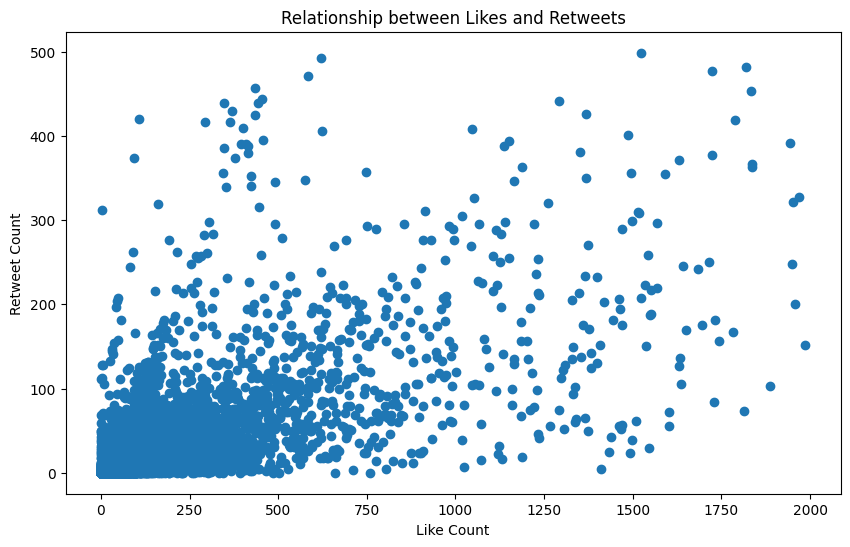

In [ ]:
import matplotlib.pyplot as plt

# Convert the filtered DataFrame to Pandas DataFrame
df_filtered_pd = df_filtered.toPandas()

# Use Matplotlib to create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_filtered_pd['like_count'], df_filtered_pd['retweet_count'])
plt.xlabel('Like Count')
plt.ylabel('Retweet Count')
plt.title('Relationship between Likes and Retweets')
plt.show()

In [ ]:
# Calculate Pearson correlation coefficient between like_count and retweet_count
correlation = df_final.select(corr("like_count", "retweet_count")).collect()[0][0]

print("Pearson correlation coefficient between likes and retweets:", correlation)

Pearson correlation coefficient between likes and retweets: 0.7311853941399662


### 4.1.2 Timeline

a. Tweets/day - Three month(Jan,Feb,Mar) timeline

In [ ]:
from pyspark.sql.functions import col
from pyspark.sql.types import DateType

from pyspark.sql.functions import count
from pyspark.sql.window import Window

# Convert date column to DateType
df_final_date = df_final.withColumn("date", col("date").cast(DateType()))

# Group by date and count the number of tweets
grouped_df = df_final_date.groupBy("date").agg(count("*").alias("count"))

# Create a window specification to order by count in descending order
window_spec = Window.orderBy(col("count").desc())

# Add a rank column based on the count in descending order
grouped_df = grouped_df.withColumn("rank", dense_rank().over(window_spec))

# Filter the top 10 dates with the highest tweet counts
top_tweet_dates = grouped_df.filter(col("rank") <= 10).orderBy(col("count").desc())

# Show the top 10 dates with the highest tweet counts
top_tweet_dates.show(10)

+----------+-----+----+
|      date|count|rank|
+----------+-----+----+
|2023-03-15|10808|   1|
|2023-02-07|10249|   2|
|2023-03-16| 8932|   3|
|2023-02-08| 8563|   4|
|2023-03-24| 8023|   5|
|2023-03-17| 7960|   6|
|2023-03-14| 7857|   7|
|2023-03-21| 7547|   8|
|2023-03-28| 7524|   9|
|2023-03-29| 7387|  10|
+----------+-----+----+



In [ ]:
# Group by date and count the number of tweets
tweets_by_day = df_final_date.groupBy("date").agg(count("*").alias("count"))

# Format date column as string in 'MM/dd' format
tweets_by_day = tweets_by_day.withColumn("date", date_format(col("date"), "MM/dd"))

# Sort the date column in ascending order
tweets_by_day = tweets_by_day.sort("date")

# Show the first few rows of the resulting DataFrame
tweets_by_day.show()

# Convert Spark DataFrame to Pandas DataFrame
tweets_by_day_pd = tweets_by_day.toPandas()


+-----+-----+
| date|count|
+-----+-----+
|01/04| 2761|
|01/05| 4137|
|01/06| 4017|
|01/07| 3486|
|01/08| 3321|
|01/09| 3995|
|01/10| 5337|
|01/11| 5606|
|01/12| 5217|
|01/13| 4750|
|01/14| 3644|
|01/15| 3238|
|01/16| 4295|
|01/17| 5352|
|01/18| 5011|
|01/19| 4796|
|01/20| 4537|
|01/21| 4001|
|01/22| 3678|
|01/23| 5481|
+-----+-----+
only showing top 20 rows



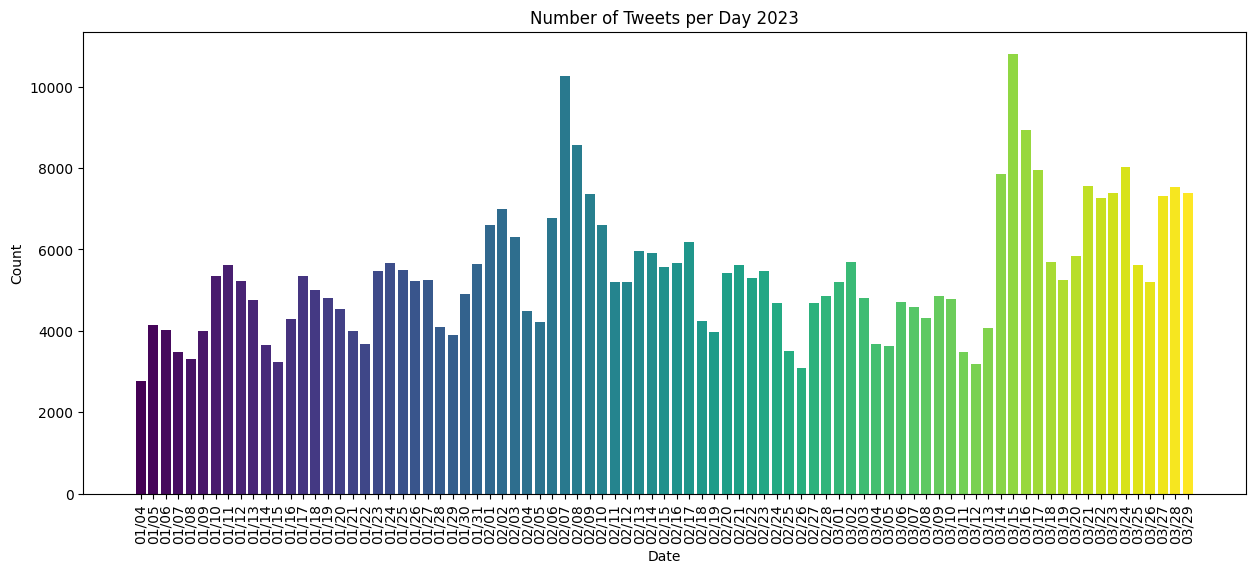

In [ ]:
import matplotlib.cm as cm
# Define custom color palette resembling 'viridis'
colors = cm.viridis(np.linspace(0, 1, len(tweets_by_day_pd)))

# Plot the bar chart using matplotlib
plt.figure(figsize=(15, 6))
plt.bar(tweets_by_day_pd['date'], tweets_by_day_pd['count'], color=colors)
plt.title('Number of Tweets per Day 2023')
plt.xlabel('Date')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

b. Tweets/week & Tweets/month

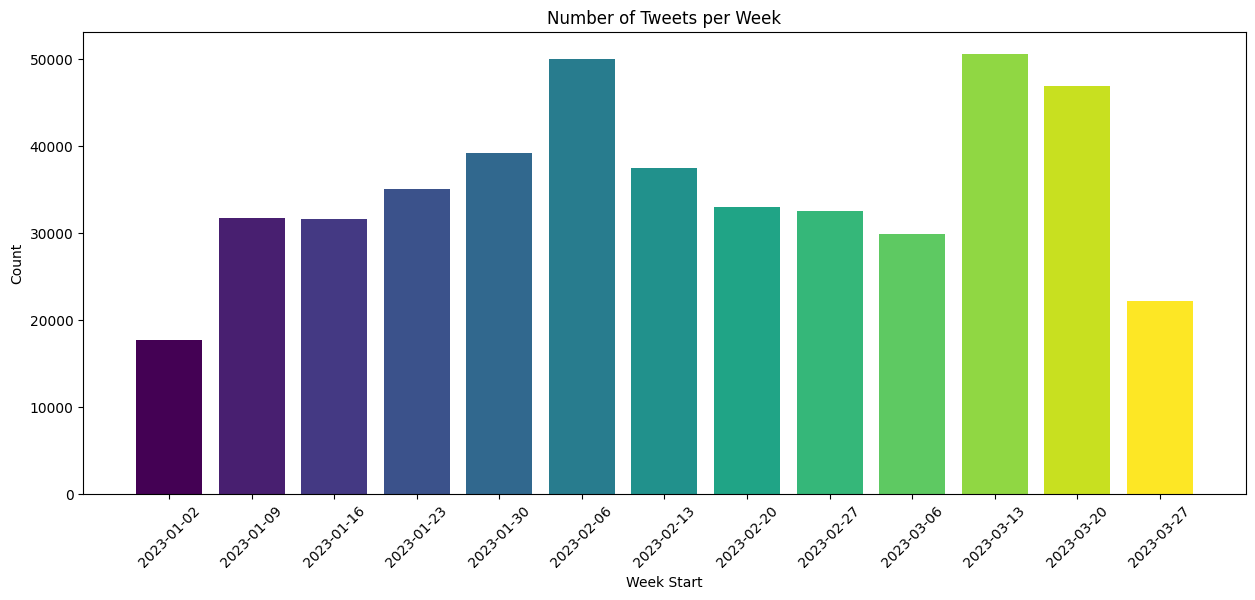

In [ ]:
# Group by week and count the number of tweets
tweets_by_week = df_final.groupBy(weekofyear("date").alias("week")).count()

# Format week start and week end columns as strings in 'yyyy-MM-dd' format
tweets_by_week = tweets_by_week.withColumn("week_start", date_format(date_add(lit("2023-01-02"), (col("week") - 1) * 7), "yyyy-MM-dd")) \
                               .withColumn("week_end", date_format(date_add(lit("2023-01-02"), col("week") * 7), "yyyy-MM-dd"))

# Sort the DataFrame by week start column
tweets_by_week = tweets_by_week.orderBy("week_start")

# Convert Spark DataFrame to Pandas DataFrame
tweets_by_week_pd = tweets_by_week.toPandas()

import matplotlib.cm as cm
# Define custom color palette resembling 'viridis'
colors_week = cm.viridis(np.linspace(0, 1, len(tweets_by_week_pd)))

# Plot bar plot
plt.figure(figsize=(15, 6))
plt.bar(tweets_by_week_pd['week_start'], tweets_by_week_pd['count'], color=colors_week)
plt.title('Number of Tweets per Week')
plt.xticks(rotation=45)
plt.xlabel('Week Start')
plt.ylabel('Count')
plt.show()

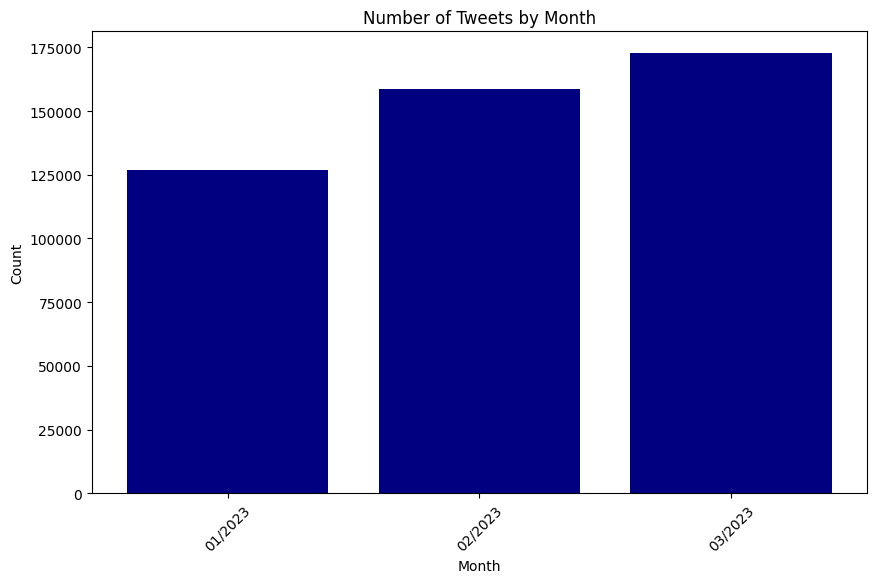

In [ ]:

# Group by month and count the number of tweets
tweets_by_month = df_final_date.groupBy(date_format("date", "MM/yyyy").alias("month")).count()

# Sort by month
tweets_by_month = tweets_by_month.orderBy("month")

# Convert Spark DataFrame to Pandas DataFrame
tweets_by_month_pd = tweets_by_month.toPandas()

# Plot bar plot
plt.figure(figsize=(10, 6))
plt.bar(tweets_by_month_pd['month'], tweets_by_month_pd['count'], color='navy')
plt.title('Number of Tweets by Month')
plt.xticks(rotation=45)
plt.xlabel('Month')
plt.ylabel('Count')
plt.show()

## 4.2 Top #Hashtag @mention and usernames

Hashtag

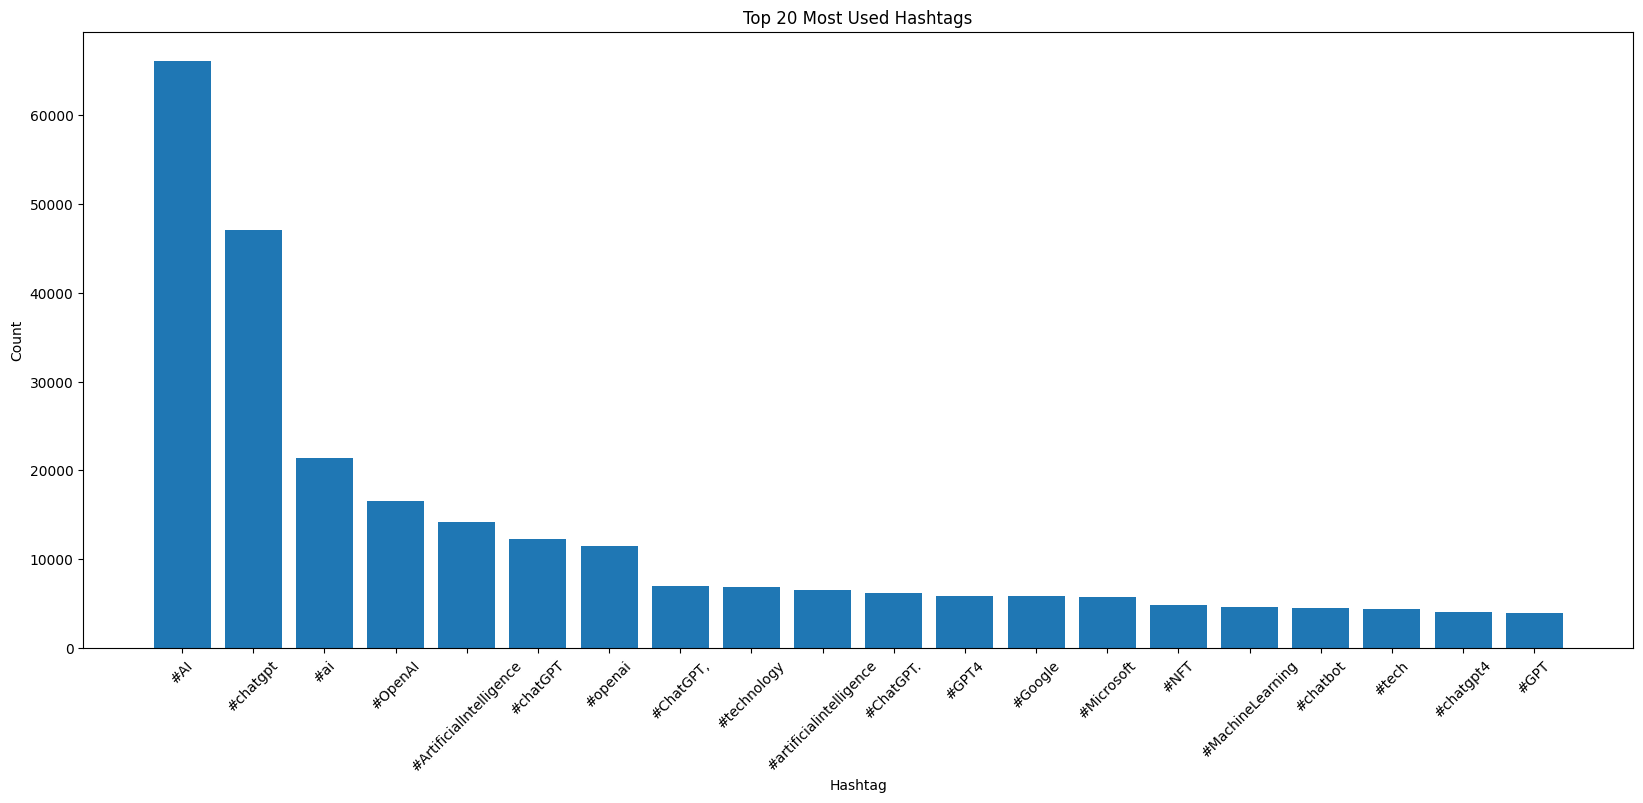

In [ ]:
# Extract hashtags from processed_content column
hashtags = df_final.select(explode(split(col("content"), r'\s+')).alias("word")) \
            .filter(col("word").rlike(r'#\w+'))\
            .filter(col("word") != "#ChatGPT")  # Remove "#ChatGPT" from the list because it's obvious

# Count hashtag occurrences
hashtags_count = hashtags.groupBy("word").agg(size(collect_list("word")).alias("count"))

# Sort by count in descending order
hashtags_count = hashtags_count.orderBy(col("count").desc())

# Show top 20 hashtags
hashtags_top_20 = hashtags_count.limit(20).toPandas()

# Generate bar plot
plt.figure(figsize=(20, 8))
plt.bar(hashtags_top_20['word'], hashtags_top_20['count'])
plt.xticks(rotation=45)
plt.title('Top 20 Most Used Hashtags')
plt.xlabel('Hashtag')
plt.ylabel('Count')
plt.show()

@mention

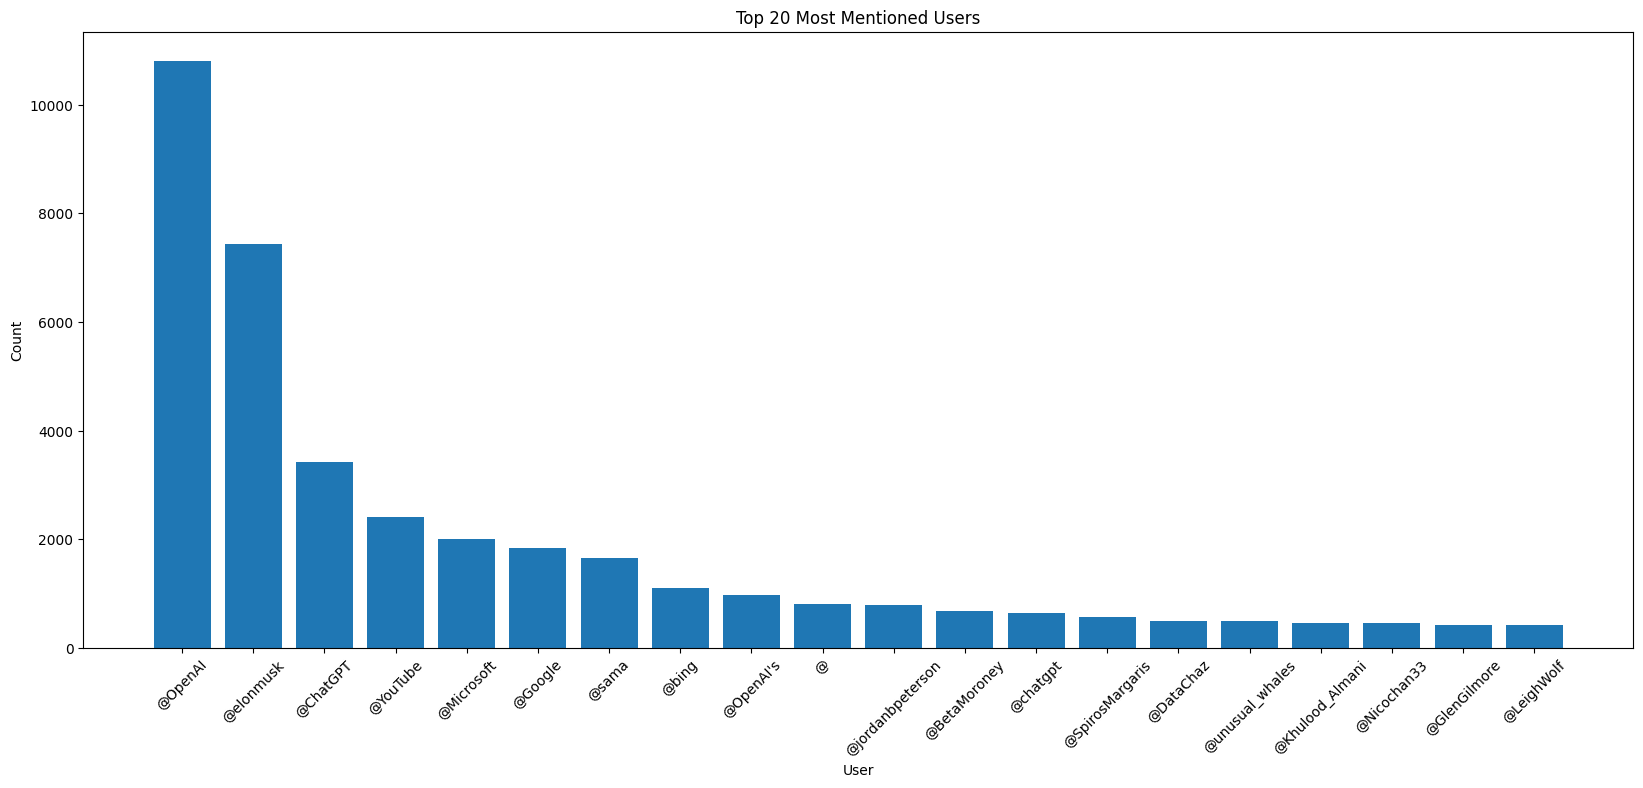

In [ ]:
# Extract mentions from content column
mentions = df_final.selectExpr("explode(split(content, ' ')) as mention") \
             .filter("mention like '@%'")  # Filter mentions that start with '@'

# Count mention occurrences
mentions_count = mentions.groupBy("mention").count()

# Sort by count in descending order
mentions_count = mentions_count.orderBy("count", ascending=False)

# Show top 20 mentions
mentions_top_20 = mentions_count.limit(20).toPandas()

# Generate bar plot
plt.figure(figsize=(20, 8))
plt.bar(mentions_top_20['mention'], mentions_top_20['count'])
plt.xticks(rotation=45)
plt.title('Top 20 Most Mentioned Users')
plt.xlabel('User')
plt.ylabel('Count')
plt.show()

Username

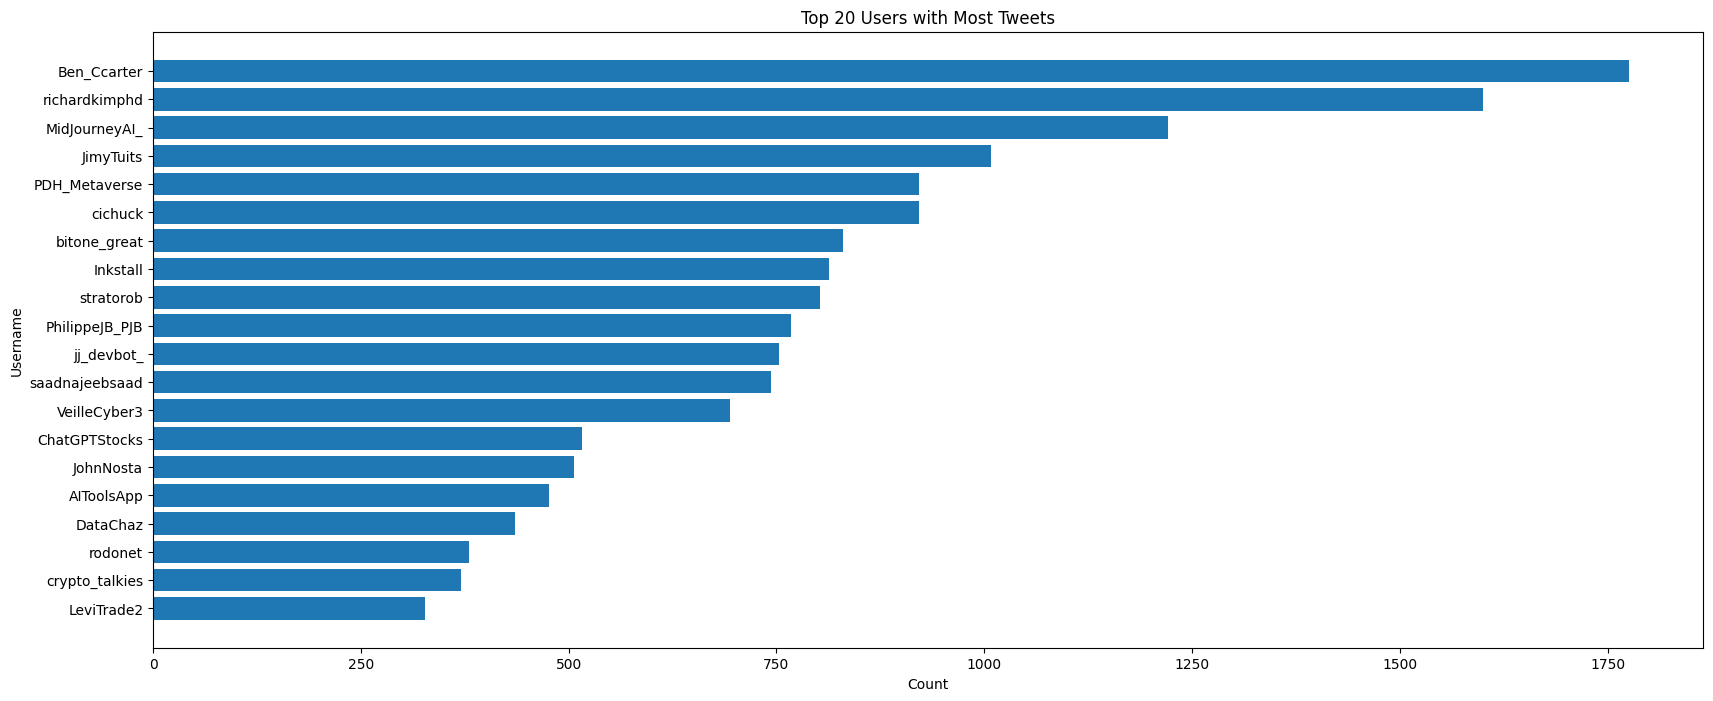

In [ ]:
# Count tweets by user
tweets_by_user = df.groupBy('username').count()

# Sort by count in descending order and reverse the order
tweets_by_user = tweets_by_user.orderBy('count', ascending=False).toPandas()[::-1]

# Show top 20 users
tweets_by_user_top_20 = tweets_by_user.tail(20)

# Generate horizontal bar plot
plt.figure(figsize=(20, 8))
plt.barh(tweets_by_user_top_20['username'], tweets_by_user_top_20['count'])
plt.xlabel('Count')
plt.ylabel('Username')
plt.title('Top 20 Users with Most Tweets')
plt.show()

## 4.3 Most liked tweets && Most Influential Users

Top 15 most liked tweets

In [ ]:
# Sort DataFrame by like_count in descending order
df_sorted = df_final.orderBy(desc('like_count'))

# Select columns date, like_count, username, and content
df_selected = df_sorted.select('date', 'like_count', 'username', 'content')

df_selected_15 = df_selected.limit(15).toPandas()



/usr/local/lib/python3.9/dist-packages/pyspark/sql/pandas/conversion.py:251: FutureWarning: Passing unit-less datetime64 dtype to .astype is deprecated and will raise in a future version. Pass 'datetime64[ns]' instead
  series = series.astype(t, copy=False)


In [ ]:
print(df_selected_15)

         date  like_count         username  \
0  2023-02-03     64094.0    MoistCr1TiKaL   
1  2023-01-13     63835.0       johnvianny   
2  2023-03-06     44940.0             rgay   
3  2023-01-07     42125.0        aaronsiim   
4  2023-01-12     38278.0  kevinschawinski   
5  2023-01-18     37048.0  writingtoriches   
6  2023-03-29     28049.0        ProudFede   
7  2023-03-14     22310.0             sama   
8  2023-01-10     21476.0      AlexHormozi   
9  2023-03-16     20827.0       lexfridman   
10 2023-03-25     19462.0       lexfridman   
11 2023-02-24     19405.0     nocontextfm1   
12 2023-01-16     17981.0          FeraSY1   
13 2023-03-02     16700.0     eossupportio   
14 2023-03-27     15789.0     mckaywrigley   

                                              content  
0   Writing erotic prompts for Chat GPT hoping to ...  
1   Best AI Tools You Need To Know\n#chatgpt #chat...  
2   I am pretty sure I am reading my first CHAT GP...  
3   ultra-modern generative ai🗨️: \n\n•

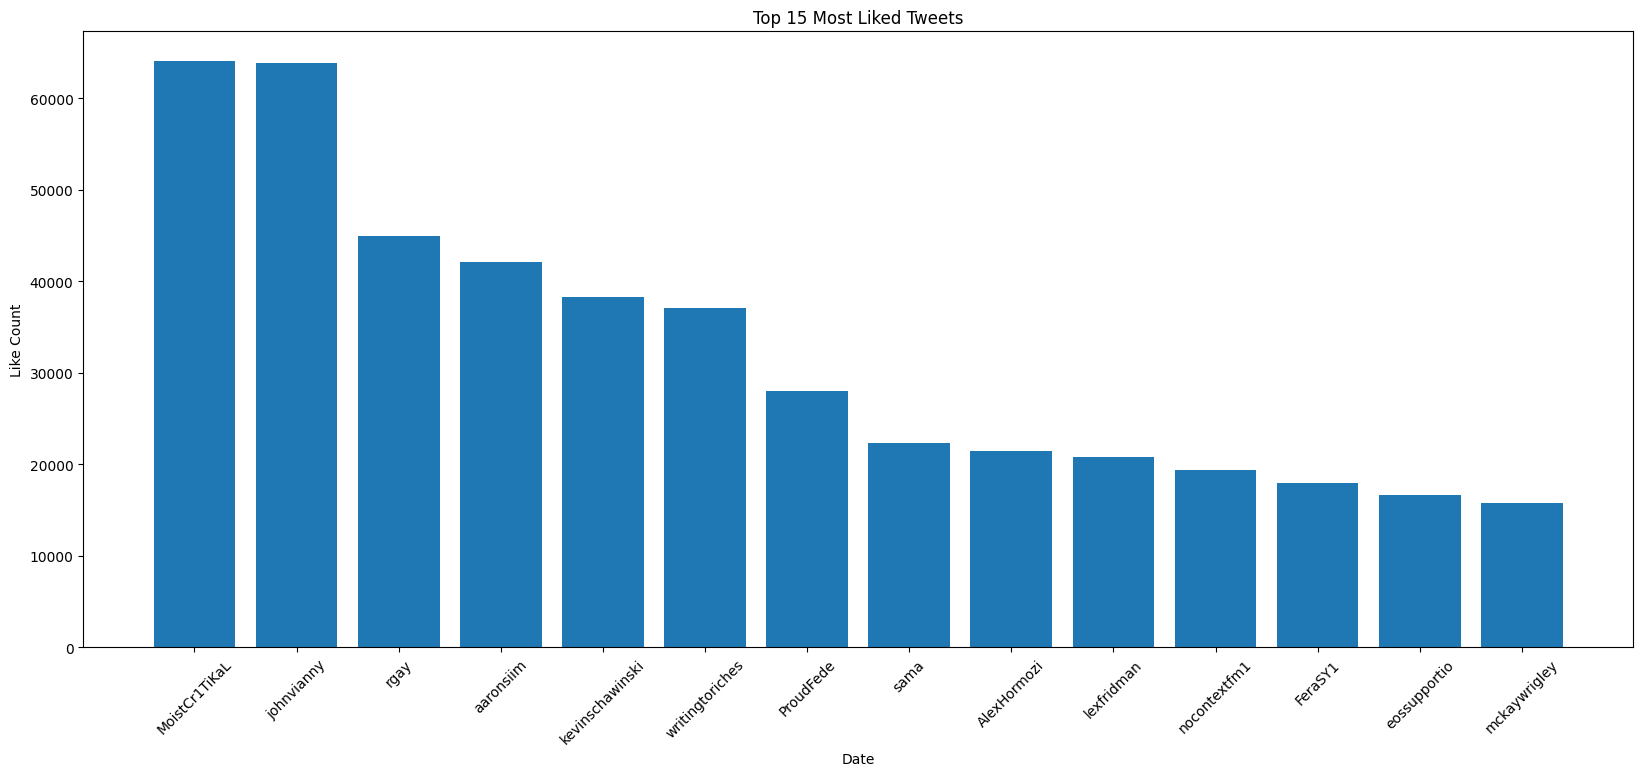

In [ ]:
# Generate bar plot
plt.figure(figsize=(20, 8))
plt.bar(df_selected_15['username'], df_selected_15['like_count'])
plt.xticks(rotation=45)
plt.title('Top 15 Tweets by Users with Most Likes')
plt.xlabel('username')
plt.ylabel('Like Count')
plt.show()

The power users! Most influential users by total number of tweet likes and retweets

In [ ]:
user_likes = df_final.groupBy('username').agg(sum('like_count').alias('total_likes'))

# Sort the DataFrame by total likes in descending order
user_likes_sorted = user_likes.orderBy(desc('total_likes'))

# Show top 10 most influential users by total likes
user_likes_top_10 = user_likes_sorted.limit(10).toPandas()

print(user_likes_top_10)

          username  total_likes
0         DataChaz     122714.0
1    MoistCr1TiKaL      64094.0
2       johnvianny      63876.0
3             rgay      44940.0
4        aaronsiim      42934.0
5       lexfridman      40289.0
6  writingtoriches      39425.0
7  kevinschawinski      38320.0
8      FirstWeekHQ      33114.0
9        ProudFede      28049.0


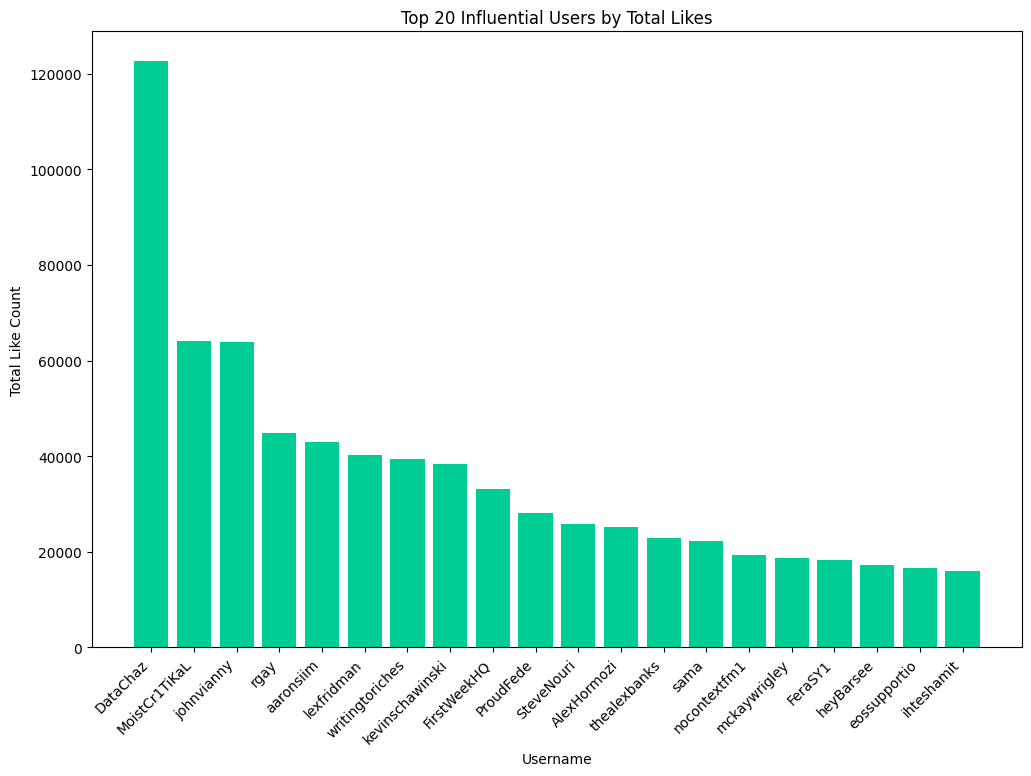

In [ ]:
# Group by 'username' and sum the 'like_count' for each user
user_likes = df_final.groupby('username').agg(sum('like_count').alias('total_likes'))
user_likes_sorted = user_likes.sort('total_likes', ascending=False).limit(20).toPandas()

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(user_likes_sorted['username'], user_likes_sorted['total_likes'], color='#00CC96')

# Add labels and title
plt.xlabel('Username')
plt.ylabel('Total Like Count')
plt.title('Top 20 Influential Users by Total Likes')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


In [ ]:
# Group by 'username' and sum the 'retweet_count' for each user
user_tweets = df_final.groupby('username').agg(sum('retweet_count').alias('total_retweets'))

# Sort the DataFrame by total retweets in descending order
user_tweets_sorted = user_tweets.sort('total_retweets', ascending=False)

# Show the top 10 most influential users by retweets
user_tweets_sorted.show(10)

+---------------+--------------+
|       username|total_retweets|
+---------------+--------------+
|       DataChaz|       25732.0|
|     johnvianny|       16096.0|
|      aaronsiim|       11710.0|
|writingtoriches|       10712.0|
|      garryflix|        8194.0|
|   crypto_bearr|        8060.0|
| TheRavenCrypto|        5429.0|
|  Dmailofficial|        5114.0|
|       ispolink|        4849.0|
|     eyishazyer|        4762.0|
+---------------+--------------+
only showing top 10 rows



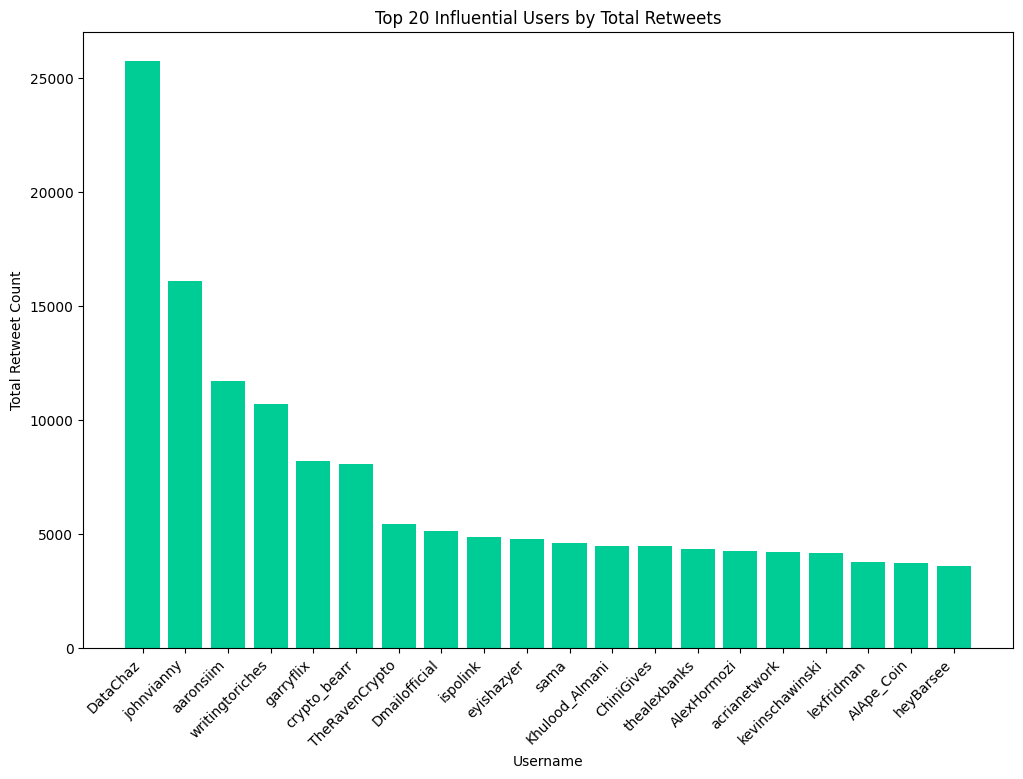

In [ ]:
# Group by 'username' and sum the 'retweet_count' for each user
user_retweets = df_final.groupby('username').agg(sum('retweet_count').alias('total_retweets'))

# Sort the DataFrame by total retweets in descending order
user_retweets_sorted = user_retweets.sort('total_retweets', ascending=False)

# Convert the Spark DataFrame to a Pandas DataFrame
user_retweets_pd = user_retweets_sorted.toPandas()

# Select top 20 users
user_retweets_pd_top20 = user_retweets_pd.head(20)

# Create a bar plot
fig, ax = plt.subplots(figsize=(12, 8))
ax.bar(user_retweets_pd_top20['username'], user_retweets_pd_top20['total_retweets'], color='#00CC96')

# Add labels and title
plt.xlabel('Username')
plt.ylabel('Total Retweet Count')
plt.title('Top 20 Influential Users by Total Retweets')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()


# 5. Text Analysis

## 5.1 Top Bigrams and Trigrams

We'll exclude 'chat', 'gpt', 'chatgpt' from n-grams to get better results focusing on other aspects related to ChatGPT

In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import ArrayType, StringType
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import gensim.corpora as corpora

# Download stopwords and WordNet lemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

# Define stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    tokens = nltk.word_tokenize(text.lower())
    # Remove stop words, words containing non-alphabetic characters, and apply lemmatization
    processed_tokens = [lemmatizer.lemmatize(w) for w in tokens if w.isalpha() and w not in stop_words and w not in ["chat", "gpt", "chatgpt"]]
    return processed_tokens

# Define UDF for preprocessing text column
preprocess_udf = udf(lambda text: preprocess_text(text), ArrayType(StringType()))

# Preprocess text column and create a list of tokenized documents
docs = df_final.select("processed_content").withColumn("processed_content", preprocess_udf("processed_content")).select("processed_content").rdd.map(lambda x: x[0])

# Convert tokenized documents to dictionary
id2word = corpora.Dictionary(docs.collect())

# Create a bag-of-words corpus
corpus = [id2word.doc2bow(doc) for doc in docs.collect()]

# Define UDF for extracting bigrams
get_bigrams_udf = udf(lambda tokens: [f"{tokens[i]} {tokens[i+1]}" for i in range(len(tokens)-1)], ArrayType(StringType()))

# Define UDF for extracting trigrams
get_trigrams_udf = udf(lambda tokens: [f"{tokens[i]} {tokens[i+1]} {tokens[i+2]}" for i in range(len(tokens)-2)], ArrayType(StringType()))

# Extract bigrams and trigrams using the UDFs
docs_with_ngrams = df_final.select("processed_content") \
                           .withColumn("processed_content", preprocess_udf("processed_content")) \
                           .withColumn("bigrams", get_bigrams_udf("processed_content")) \
                           .withColumn("trigrams", get_trigrams_udf("processed_content"))

# Convert docs_with_ngrams to an RDD
docs_rdd = docs_with_ngrams.select("bigrams", "trigrams").rdd.map(tuple)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
# Get top 10 bigrams
top_bigrams = docs_rdd.flatMap(lambda x: x[0]) \
                      .map(lambda x: (x, 1)) \
                      .reduceByKey(lambda x, y: x + y) \
                      .sortBy(lambda x: x[1], ascending=False) \
                      .take(10)

# Get top 10 trigrams
top_trigrams = docs_rdd.flatMap(lambda x: x[1]) \
                       .map(lambda x: (x, 1)) \
                       .reduceByKey(lambda x, y: x + y) \
                       .sortBy(lambda x: x[1], ascending=False) \
                       .take(10)


In [ ]:
# Print top 10 bigrams
for bigram in top_bigrams:
    print(bigram[0], ':', bigram[1])

artificial intelligence : 6860
language model : 6324
ai tool : 4471
search engine : 3604
generative ai : 3291
asked write : 2974
look like : 2526
gon na : 2461
ai chatbot : 2101
open ai : 1987


In [ ]:
# Print top 10 trigrams
for trigram in top_trigrams:
    print(trigram[0], ':', trigram[1])

large language model : 1848
ai language model : 1063
natural language processing : 864
generated based instruction : 744
sunrise sunset pm : 740
pm current temp : 740
current temp c : 740
wind speed status : 740
sunset pm current : 740
temp c humidity : 740


## 5.2 WordClouds

Here we generate a unigram wordcloud. First, we extract the data of processed_content to a txt file. And then we generate a wordcloud using twitter logo.

In [ ]:
path = '/content/drive/My Drive/BADM 358/final project/'

# Select the processed_content column and convert it to an RDD
processed_content_rdd = df_final.select("processed_content").rdd

# Extract the text data from the processed_content column and join it into a single string
text_data = processed_content_rdd.map(lambda x: x[0]).filter(lambda x: x is not None).collect()
text_data_str = "\n".join(text_data)

# Write the text data to a text file
with open(path+"text_data.txt", "w") as f:
    f.write(text_data_str)


In [ ]:
from random import choice

# Define a custom color function for Wordcloud
def custom_color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    colors = ['#1DA1F2', '#00CC96', '#FF5733', '#FFC300', '#E91E63', '#9C27B0', '#673AB7']
    return choice(colors)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


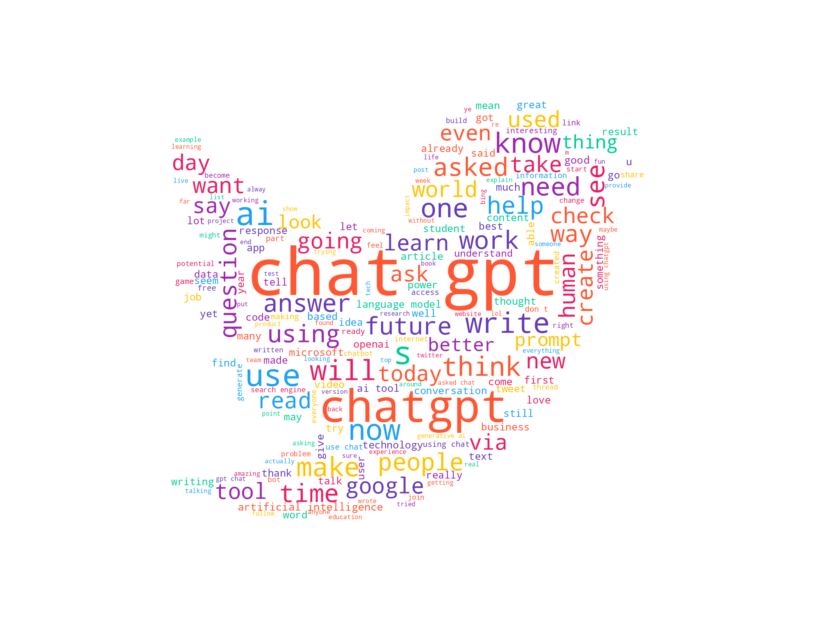

In [ ]:
import io
import numpy as np
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
import nltk
nltk.download('wordnet')

# Load the text file
with io.open(path+"text_data.txt", 'r', encoding='utf8') as file:
    text = file.read()

# Create a word cloud object
mask = np.array(Image.open(path+"Twitter.jpg")) # use a mask image to shape the wordcloud
mask = np.array(mask)
wordcloud = WordCloud(width = 800, height = 800, 
                      background_color ='white', 
                      stopwords = set(STOPWORDS), 
                      mask=mask, color_func=custom_color_func,
                      min_font_size = 10).generate(text)

# Plot the word cloud
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.tight_layout(pad = 0)
  
# Show the plot
plt.show()

# Save the wordcloud to a file
wordcloud.to_file(path+"wordcloud.png")


# 6. Sentiment Analysis Result

##6.1 Overall sentiment

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType
from nltk import download

# Download VADER lexicon
download('vader_lexicon')

# Create a UDF to apply VADER analyzer on each text
def vader_polarity(text):
    sid = SentimentIntensityAnalyzer()
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']

# Register the UDF with Spark
vader_polarity_udf = udf(vader_polarity, FloatType())

# Add a new column 'vader_polarity' to store the VADER compound score
df_vader = df_final.withColumn('vader_polarity', vader_polarity_udf(df['processed_content']))

# Show the result
df_vader.show()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


+-------------------+-------------------+--------------------+---------------+----------+-------------+--------------------+--------------+
|               date|                 id|             content|       username|like_count|retweet_count|   processed_content|vader_polarity|
+-------------------+-------------------+--------------------+---------------+----------+-------------+--------------------+--------------+
|2023-01-04 00:00:00|1610743709032660993|@WIRED "Ant grows...|          seaef|       1.0|          0.0| "ant grows big, ...|       -0.1027|
|2023-01-04 00:00:00|1610737365626294272|@jollygreenmoney ...|   SpaanBastian|       4.0|          0.0| $vai is the futu...|        0.4019|
|2023-01-04 00:00:00|1610538946030624769|@OpenAI 's Chat G...|   KelvinOdoobo|       0.0|          0.0| 's chat gpt migh...|       -0.4939|
|2023-01-04 00:00:00|1610651082748821506|#100DaysOfCode - ...|     EveryEpoch|       6.0|          3.0| - day 1 yesterda...|        0.0772|
|2023-01-04 00:00:00

In [ ]:
from textblob import TextBlob

# Create a UDF to apply TextBlob polarity analysis on each text
def blob_polarity(text):
    blob = TextBlob(text)
    return blob.sentiment.polarity

# Register the UDF with Spark
blob_polarity_udf = udf(blob_polarity, FloatType())

# Add a new column 'blob_polarity' to store the TextBlob polarity scores
df_v_t = df_vader.withColumn('blob_polarity', blob_polarity_udf(df['processed_content']))

# Show the result
df_v_t.show()

+-------------------+-------------------+--------------------+---------------+----------+-------------+--------------------+--------------+-------------+
|               date|                 id|             content|       username|like_count|retweet_count|   processed_content|vader_polarity|blob_polarity|
+-------------------+-------------------+--------------------+---------------+----------+-------------+--------------------+--------------+-------------+
|2023-01-04 00:00:00|1610743709032660993|@WIRED "Ant grows...|          seaef|       1.0|          0.0| "ant grows big, ...|       -0.1027|          0.0|
|2023-01-04 00:00:00|1610737365626294272|@jollygreenmoney ...|   SpaanBastian|       4.0|          0.0| $vai is the futu...|        0.4019|          0.0|
|2023-01-04 00:00:00|1610538946030624769|@OpenAI 's Chat G...|   KelvinOdoobo|       0.0|          0.0| 's chat gpt migh...|       -0.4939|      -0.2375|
|2023-01-04 00:00:00|1610651082748821506|#100DaysOfCode - ...|     EveryEpoc

In [ ]:
# Select the desired columns
polarity_df = df_v_t.select(col('vader_polarity').alias('Vader'), col('blob_polarity').alias('TextBlob'))

# Show the result
polarity_df.show()

+-------+----------+
|  Vader|  TextBlob|
+-------+----------+
|    0.0|       0.0|
| 0.9424|0.33035713|
| 0.7506|0.18138528|
| 0.8329|0.53333336|
|-0.2235|     -0.35|
| 0.7579|       0.5|
| 0.8705|   0.35625|
|    0.0|      -0.3|
|    0.0|       0.0|
| 0.8074|     -0.08|
|    0.0|       0.0|
| 0.2023|0.19166666|
|-0.4678|0.11212121|
| 0.5827|       1.0|
| 0.1531|    -0.625|
| 0.4939|       0.0|
| 0.4926|    0.2125|
| 0.4753|      -0.2|
| 0.0772|      0.15|
| 0.4389|       0.0|
+-------+----------+
only showing top 20 rows



In [ ]:
polarity_pd_df = polarity_df.toPandas()

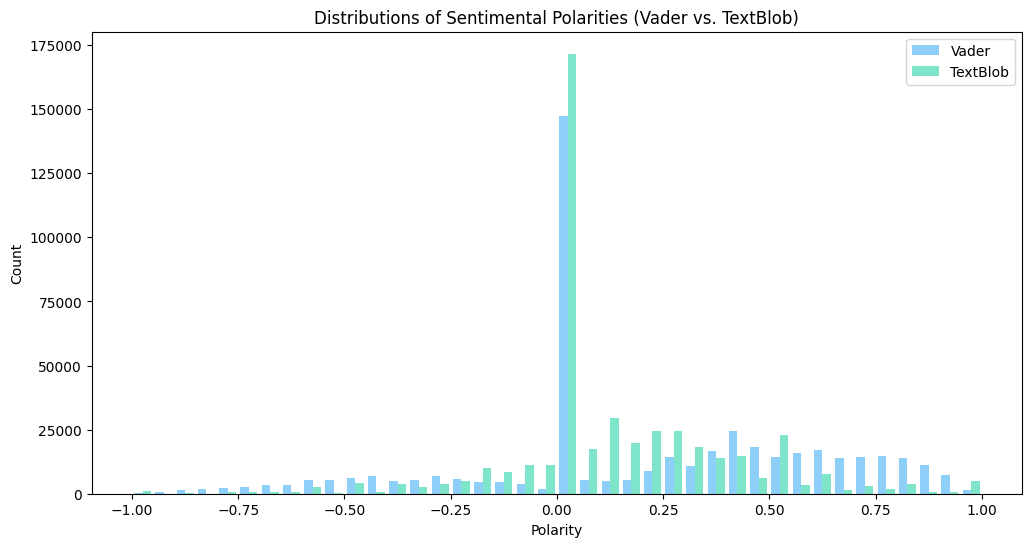

In [ ]:
# Create histogram using matplotlib
plt.figure(figsize=(12, 6))
plt.hist([polarity_pd_df["Vader"], polarity_pd_df["TextBlob"]], bins=40, alpha=0.5, color=['#1DA1F2', '#00CC96'])
plt.title('Distributions of Sentimental Polarities (Vader vs. TextBlob)')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.legend(['Vader', 'TextBlob'])
plt.show()

Note: 

Vader is a rule-based sentiment analysis tool that is specifically designed for social media text and can handle text with emojis, slang, and informal language. It provides a compound score that represents the overall sentiment polarity, ranging from -1 (negative) to 1 (positive), along with scores for positive, negative, and neutral sentiment.

TextBlob, on the other hand, is a general-purpose natural language processing library that includes sentiment analysis capabilities. It provides a polarity score that ranges from -1 (negative) to 1 (positive) and a subjectivity score that measures the degree of subjectivity in the text, ranging from 0 (objective) to 1 (subjective).

Note: 

In particular, if the histogram shows a higher frequency of positive sentiment polarities (i.e., higher values on the polarity scale) for TextBlob compared to Vader, it may suggest that TextBlob is generally more positive in its sentiment analysis compared to Vader. This could mean that TextBlob tends to assign higher positive sentiment scores to the text data, while Vader may be relatively more conservative in assigning positive sentiment scores.

On the other hand, if the histogram shows a higher frequency of negative sentiment polarities (i.e., lower values on the polarity scale) for TextBlob compared to Vader, it may suggest that TextBlob is generally more negative in its sentiment analysis compared to Vader. This could mean that TextBlob tends to assign lower negative sentiment scores to the text data, while Vader may be relatively more conservative in assigning negative sentiment scores.